In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import collections
from array import array

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_all_combine_mar18/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')


Welcome to JupyROOT 6.10/08


In [2]:
pot_data =    7.644e+18

outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_genie_all_combine.root","RECREATE");


In [3]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [4]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# All Genie cross section variation 100 multisims, mitigation cos(Theta)

In [5]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [6]:
path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
#f_mom_tmp = ROOT.TFile.Open(path+"xsec_all_genie/All_Genie.root", 'read')
f_mom = ROOT.TFile.Open(path+"xsec_all_genie/All_Genie.root", 'read')


In [7]:
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
num_universes = 100

In [8]:
h_data = f_mom_tmp.Get('h_data_mom')
h_ext = f_mom_tmp.Get('h_ext_mom')
h_dirt = f_mom_tmp.Get('h_dirt_mom')

print h_data.Integral(0,binnum+1)
print h_ext.Integral(0,binnum+1)
print h_dirt.Integral(0,binnum+1)

1348.0
142.179031156
32.1298251934


In [9]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [10]:
h_bkg = []
h_sig = []
h_true = []
h_mitigation_matrix = []
i = 0
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
for uni in range(num_universes):
    h_bkg.append(f_mom.Get('h_1d_bkg['+str(uni)+']'))
    h_sig.append(f_mom.Get('h_1d['+str(uni)+']'))
    h_true.append(f_mom.Get('h_1d_true['+str(uni)+']'))
    h_mitigation_matrix.append(f_mom.Get('h_mitigation_matrix['+str(uni)+']'))

In [11]:
print h_sig[99].Integral(0,binnum+1),h_true[99].Integral(0,binnum+1)
#h_mitigation_matrix[50].Draw('colz text')
#c1.Draw()

201232.555664 392357.88623


In [12]:
mitigation_matrix = np.zeros((num_universes,7,6))
for uni in range(num_universes):
    for j in range(1,binnum+1):
        for i in range(1,binnum+2):
            mitigation_matrix[uni,i-1,j-1]= h_mitigation_matrix[uni].GetBinContent(i,j)


In [13]:
# calculate e tilde for all universes
N_sel = np.zeros((num_universes,6))
N_gen = np.zeros((num_universes,6))
eff_tilde = np.zeros((num_universes,7))
for uni in range(num_universes):
    for i in range(1,binnum+1):
        N_sel[uni][i-1] = h_sig[uni].GetBinContent(i)
        N_gen[uni][i-1] = h_true[uni].GetBinContent(i)
    eff_tilde[uni] = mitigation_matrix[uni].dot(N_sel[uni])/(mitigation_matrix[uni].dot(N_gen[uni]))
    

In [14]:
print eff_tilde[99]
#del h_eff_true[:]
#del h_eff_tilde[:]

[0.19769356 0.34072053 0.44536611 0.54369183 0.63582633 0.66206957
 0.61150157]


In [15]:
#h_eff_tilde[99].Draw()
#c1.Draw()

In [16]:
h_eff_true = {}
h_eff_tilde = {}
for uni in range(num_universes):
    h_eff_tilde[uni] = ROOT.TH1F("h_eff_tilde["+str(uni)+']','Efficiency tilde',binnum,array('f',mom_bins))
    h_eff_true[uni] = h_sig[uni].Clone()
    #h_eff_true[uni].Sumw2()
    h_eff_true[uni].Divide(h_true[uni])
    for i in range(1,binnum+1):
        h_eff_tilde[uni].SetBinContent(i,eff_tilde[uni][i-1])
        h_eff_tilde[uni].SetBinError(i,h_eff_true[uni].GetBinError(i))
    h_eff_tilde[uni].SetYTitle("reconstructed efficiency")
    h_eff_tilde[uni].SetXTitle("p_{\mu} \t [GeV]")
    

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_eff_tilde_all_genie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_eff_tilde_all_genie.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_eff_tilde_all_genie.pdf has been created


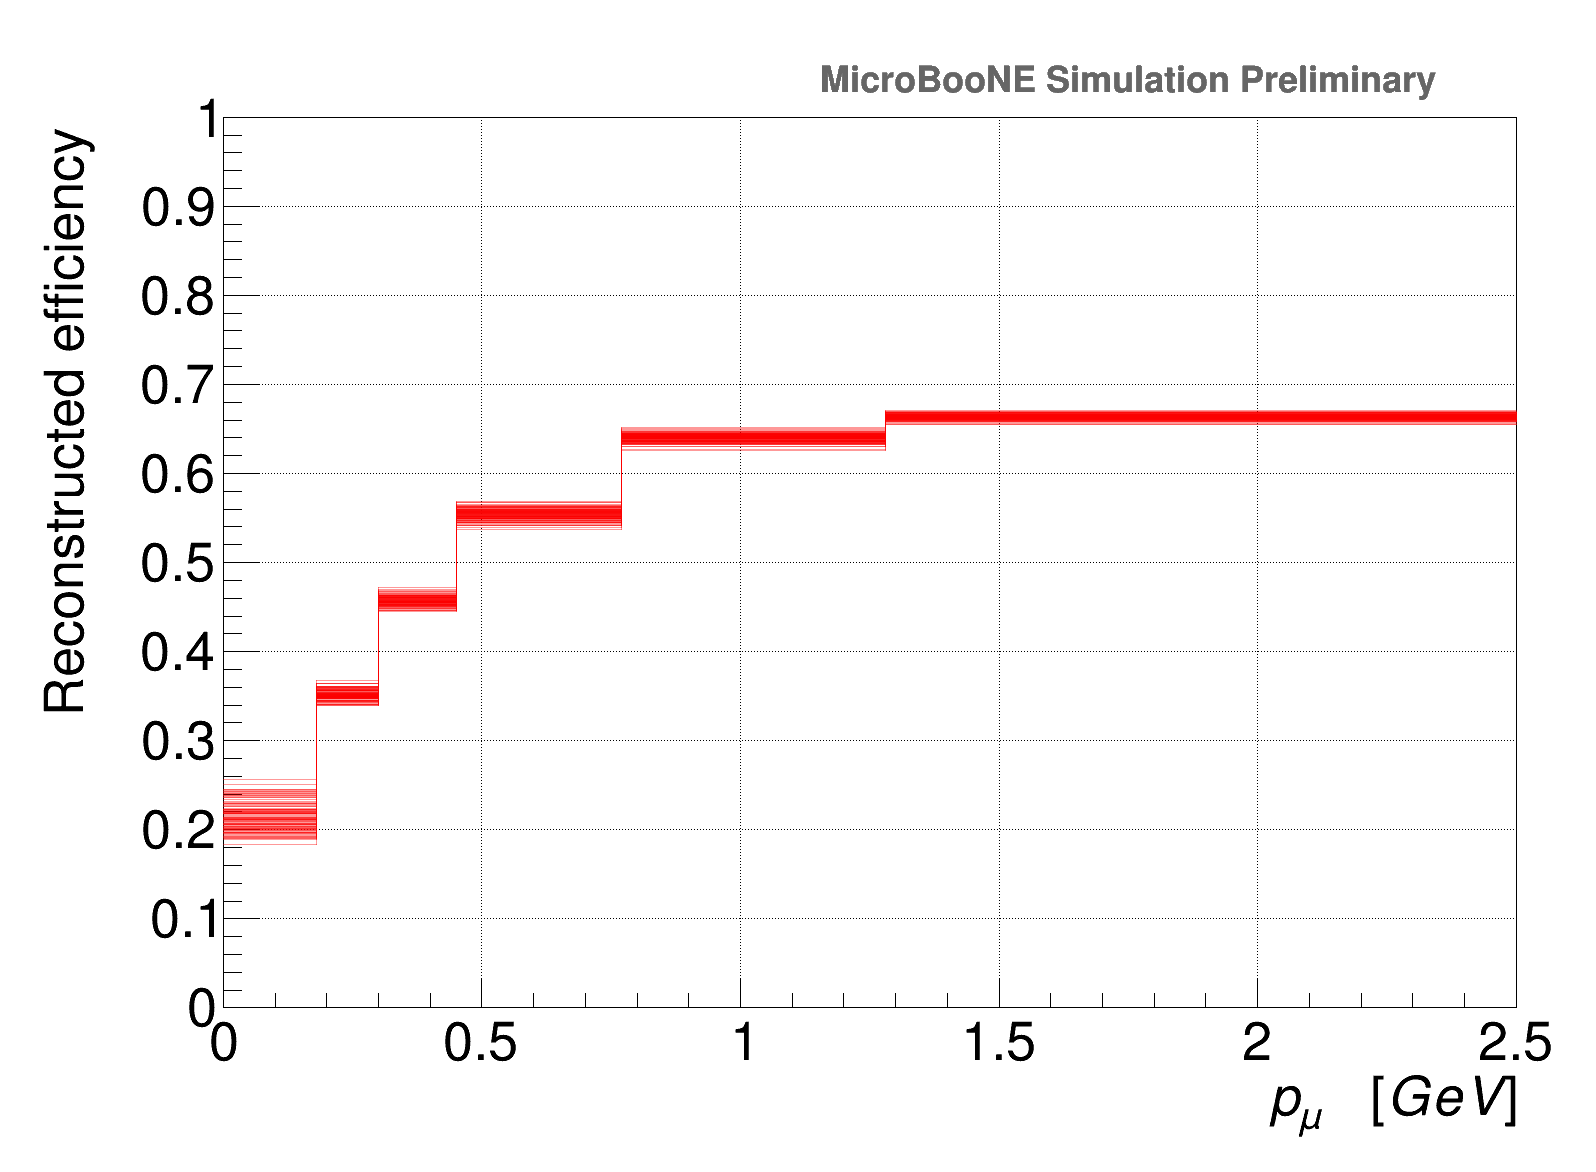

In [17]:

h_eff_tilde[0].Draw('hist')
for uni in range(num_universes): 
    h_eff_tilde[uni].SetMaximum(1)
    h_eff_tilde[uni].SetMinimum(0)
    h_eff_tilde[uni].SetLineColorAlpha(ROOT.kRed,0.4)
    h_eff_tilde[uni].SetYTitle("Reconstructed efficiency")
    h_eff_tilde[uni].SetXTitle("p_{\mu} \t [GeV]")
    h_eff_tilde[uni].GetYaxis().SetTitleSize(0.05)
    h_eff_tilde[uni].GetYaxis().SetTitleOffset(0.0)
    h_eff_tilde[uni].GetYaxis().SetLabelSize(0.05)
    h_eff_tilde[uni].GetXaxis().SetTitleSize(0.05)
    h_eff_tilde[uni].GetXaxis().SetLabelSize(0.05)
    h_eff_tilde[uni].GetXaxis().SetTitleOffset(1)
    #h_covariance.SetLineColor(ROOT.kBlack)
    h_eff_tilde[uni].SetLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(5)
    h_eff_tilde[uni].Draw('hist same')
#h_eff_tilde.Draw('hist same') 
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_tilde_all_genie.png")
c1.SaveAs(outputdir_root + "h_eff_tilde_all_genie.root")
c1.SaveAs(outputdir_pdf + "h_eff_tilde_all_genie.pdf")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_eff_true_all_genie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_eff_true_all_genie.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_eff_true_all_genie.pdf has been created


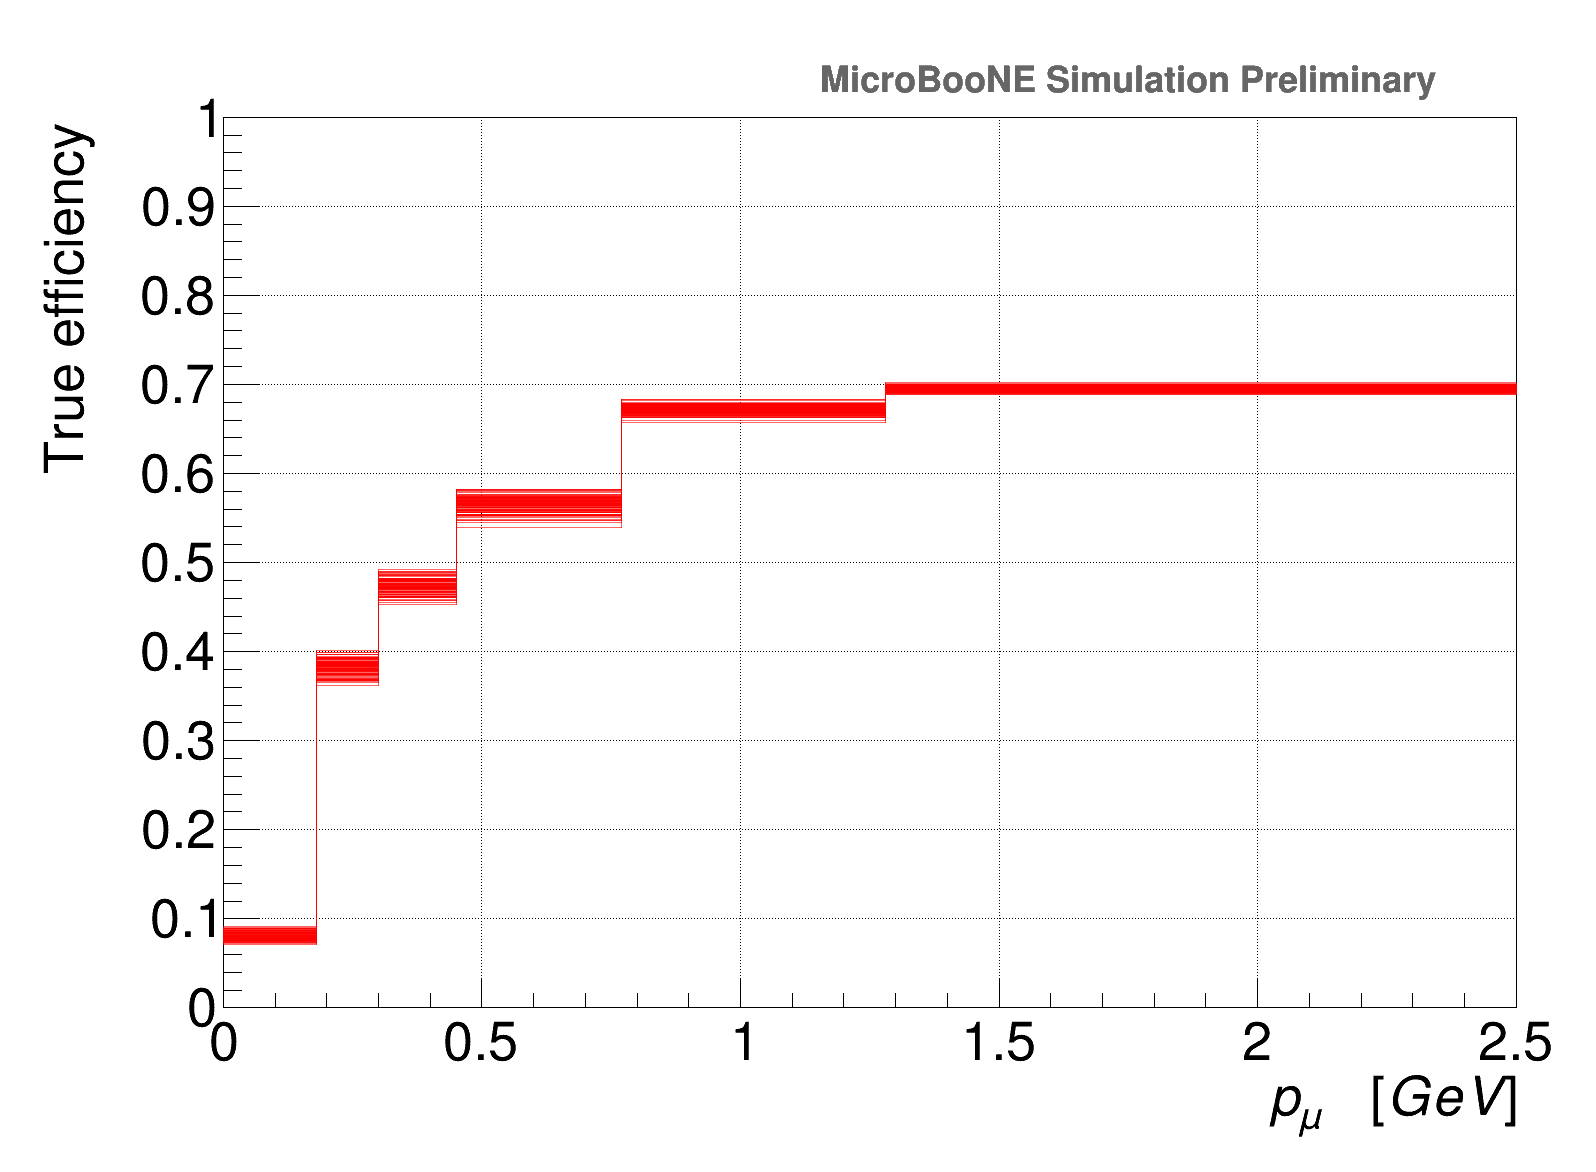

In [18]:
h_eff_true = {}

#h_eff_tilde[0].Draw('hist')
for uni in range(num_universes): 
    h_eff_true[uni] = h_sig[uni].Clone()
    h_eff_true[uni].Divide(h_true[uni])
    h_eff_true[uni].SetMaximum(1)
    h_eff_true[uni].SetMinimum(0)
    h_eff_true[uni].SetLineColorAlpha(ROOT.kRed,0.6)
    h_eff_true[uni].SetYTitle("True efficiency")
    h_eff_true[uni].SetXTitle("p_{\mu} \t [GeV]")
    h_eff_true[uni].GetYaxis().SetTitleSize(0.05)
    h_eff_true[uni].GetYaxis().SetTitleOffset(0.0)
    h_eff_true[uni].GetYaxis().SetLabelSize(0.05)
    h_eff_true[uni].GetXaxis().SetTitleSize(0.05)
    h_eff_true[uni].GetXaxis().SetLabelSize(0.05)
    h_eff_true[uni].GetXaxis().SetTitleOffset(1)
    #h_covariance.SetLineColor(ROOT.kBlack)
    h_eff_true[uni].SetLineWidth(1)
    #ROOT.gStyle.SetEndErrorSize(5)
    if(uni==0):
        h_eff_true[uni].Draw('hist')
    else:
        h_eff_true[uni].Draw('hist same')
#h_eff_tilde.Draw('hist same')   
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_true_all_genie.png")
c1.SaveAs(outputdir_root + "h_eff_true_all_genie.root")
c1.SaveAs(outputdir_pdf + "h_eff_true_all_genie.pdf")

In [19]:
h_xsec = {}
for uni in range(num_universes): 
    h_xsec[uni] = h_data.Clone()
    #h_xsec[uni].Sumw2()
    h_xsec[uni].Add(h_ext,-1)
    h_xsec[uni].Add(h_dirt,-1)
    h_xsec[uni].Add(h_bkg[uni],-1)
    #print h_xsec[uni].GetSumOfWeights()

In [20]:
for uni in range(num_universes): 
    h_xsec[uni].Divide(h_eff_tilde[uni])
    h_xsec[uni].Scale(1.0/(N_tot * beam_flux))
    for i in range(1,binnum+1):
        h_xsec[uni].SetBinContent(i,h_xsec[uni].GetBinContent(i)/h_xsec[uni].GetBinWidth(i))
        h_xsec[uni].SetBinError(i,h_xsec[uni].GetBinError(i)/h_xsec[uni].GetBinWidth(i))

    #h_xsec[uni].Write('h_xsec['+str(uni)+']')

In [21]:
for i in range(num_universes): 
    h_xsec[i].Scale(1e38)

In [22]:
path_cv = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_momentum_wighted.root", 'read')

h_xsec_cv = f_cv.Get('h_xsec_data')

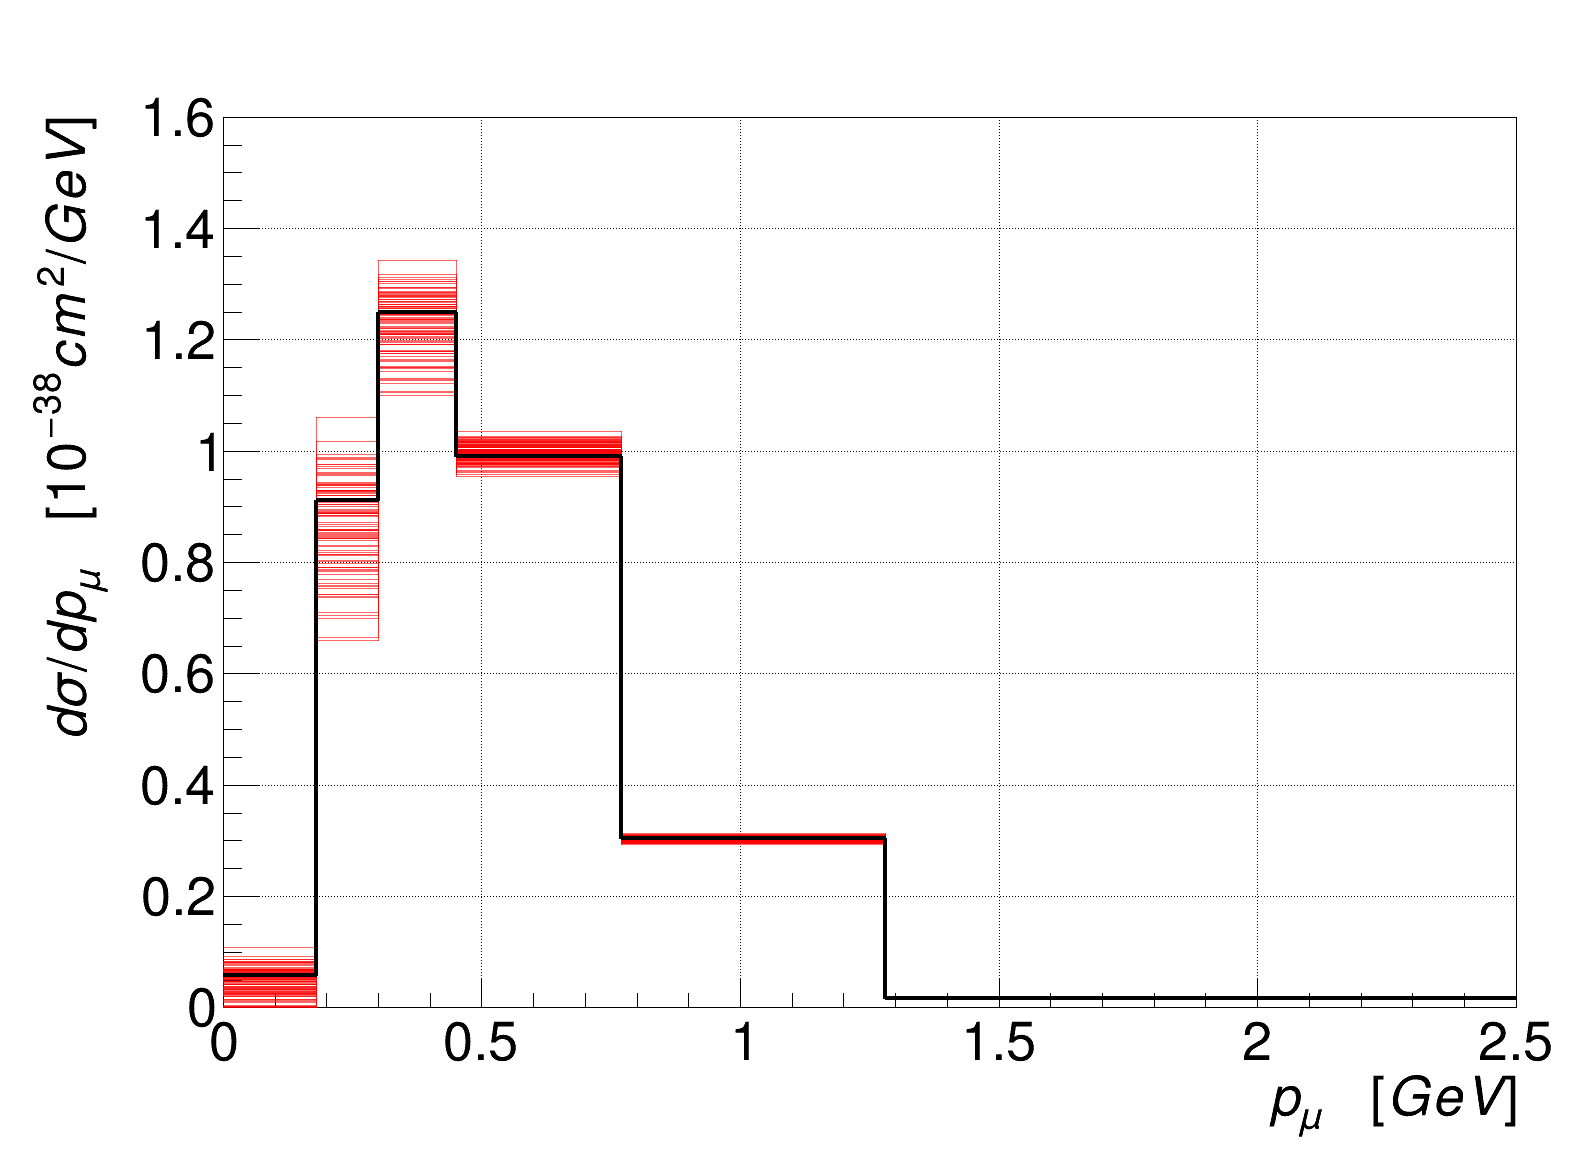

In [23]:
h_xsec_cv.Draw('hist')
for uni in range(num_universes): 
    h_xsec[uni].SetMaximum(1.6)
    h_xsec[uni].SetLineColorAlpha(ROOT.kRed,0.6)
    h_xsec[uni].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_xsec[uni].SetXTitle("p_{\mu} [GeV]")
    h_xsec[uni].Draw('hist same')
h_xsec_cv.Draw('hist same')   
c1.Draw()
    

In [24]:
num_bins = h_xsec[0].GetNbinsX()

xsec_cov_matrix = np.zeros((num_bins,num_bins))
xsec_frac_cov_matrix = np.zeros((num_bins,num_bins))
#xsec_diff_matrix = np.zeros((num_bins))
for uni in range(num_universes):
    xsec_diff_matrix = np.zeros((num_bins))
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_xsec_cv.GetBinContent(b+1)-h_xsec[uni].GetBinContent(b+1) )
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
xsec_cov_matrix = xsec_cov_matrix/num_universes
    
xsec_corr_matrix = np.zeros((num_bins,num_bins))
for i in range(num_bins): 
    for j in range(num_bins):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))
        xsec_frac_cov_matrix[i][j] = xsec_cov_matrix[i][j]/(h_xsec_cv.GetBinContent(i+1)*h_xsec_cv.GetBinContent(j+1))
#np.save(output_filedir+'correlation_detsys',xsec_corr_matrix)
#np.save(output_filedir+'covariance_detsys',xsec_cov_matrix)

In [35]:
RootFile = ROOT.TFile(output_filedir+"xsec_genie_all_combine.root","RECREATE");

673

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_correlation_detsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_correlation_detsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_correlation_detsys.pdf has been created


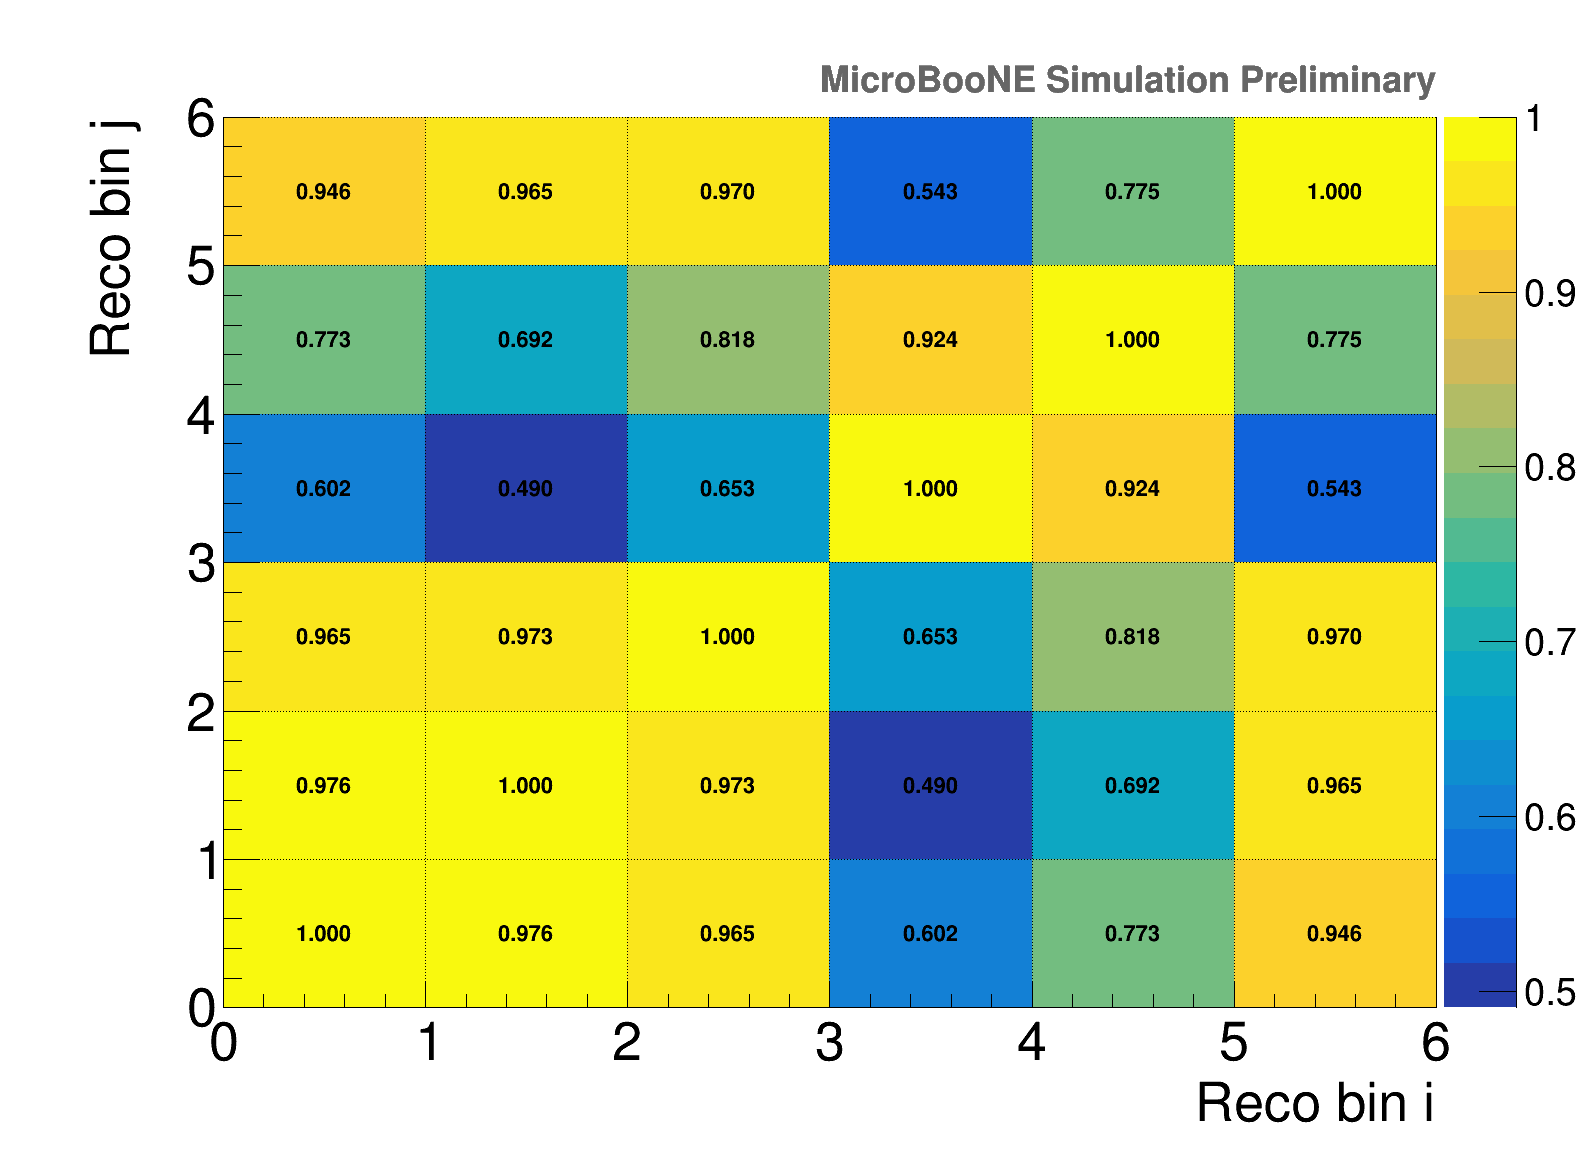

In [36]:
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation = ROOT.TH2D("h_correlation",'Correlation matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_correlation.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_correlation.SetXTitle("Reco bin i")
h_correlation.SetYTitle("Reco bin j")
h_correlation.GetYaxis().SetTitleSize(0.05)
h_correlation.GetYaxis().SetTitleOffset(0.0)
h_correlation.GetYaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleSize(0.05)
h_correlation.GetXaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleOffset(1)
h_correlation.SetLineColor(ROOT.kBlack)
h_correlation.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')
#h_correlation.SetMinimum(-1)
h_correlation.Draw('colz')
h_correlation.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_detsys.png")
c1.SaveAs(outputdir_root + "h_correlation_detsys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_detsys.pdf")
h_correlation.Write('h_correlation')

705

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_covariance_detsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_covariance_detsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_covariance_detsys.pdf has been created


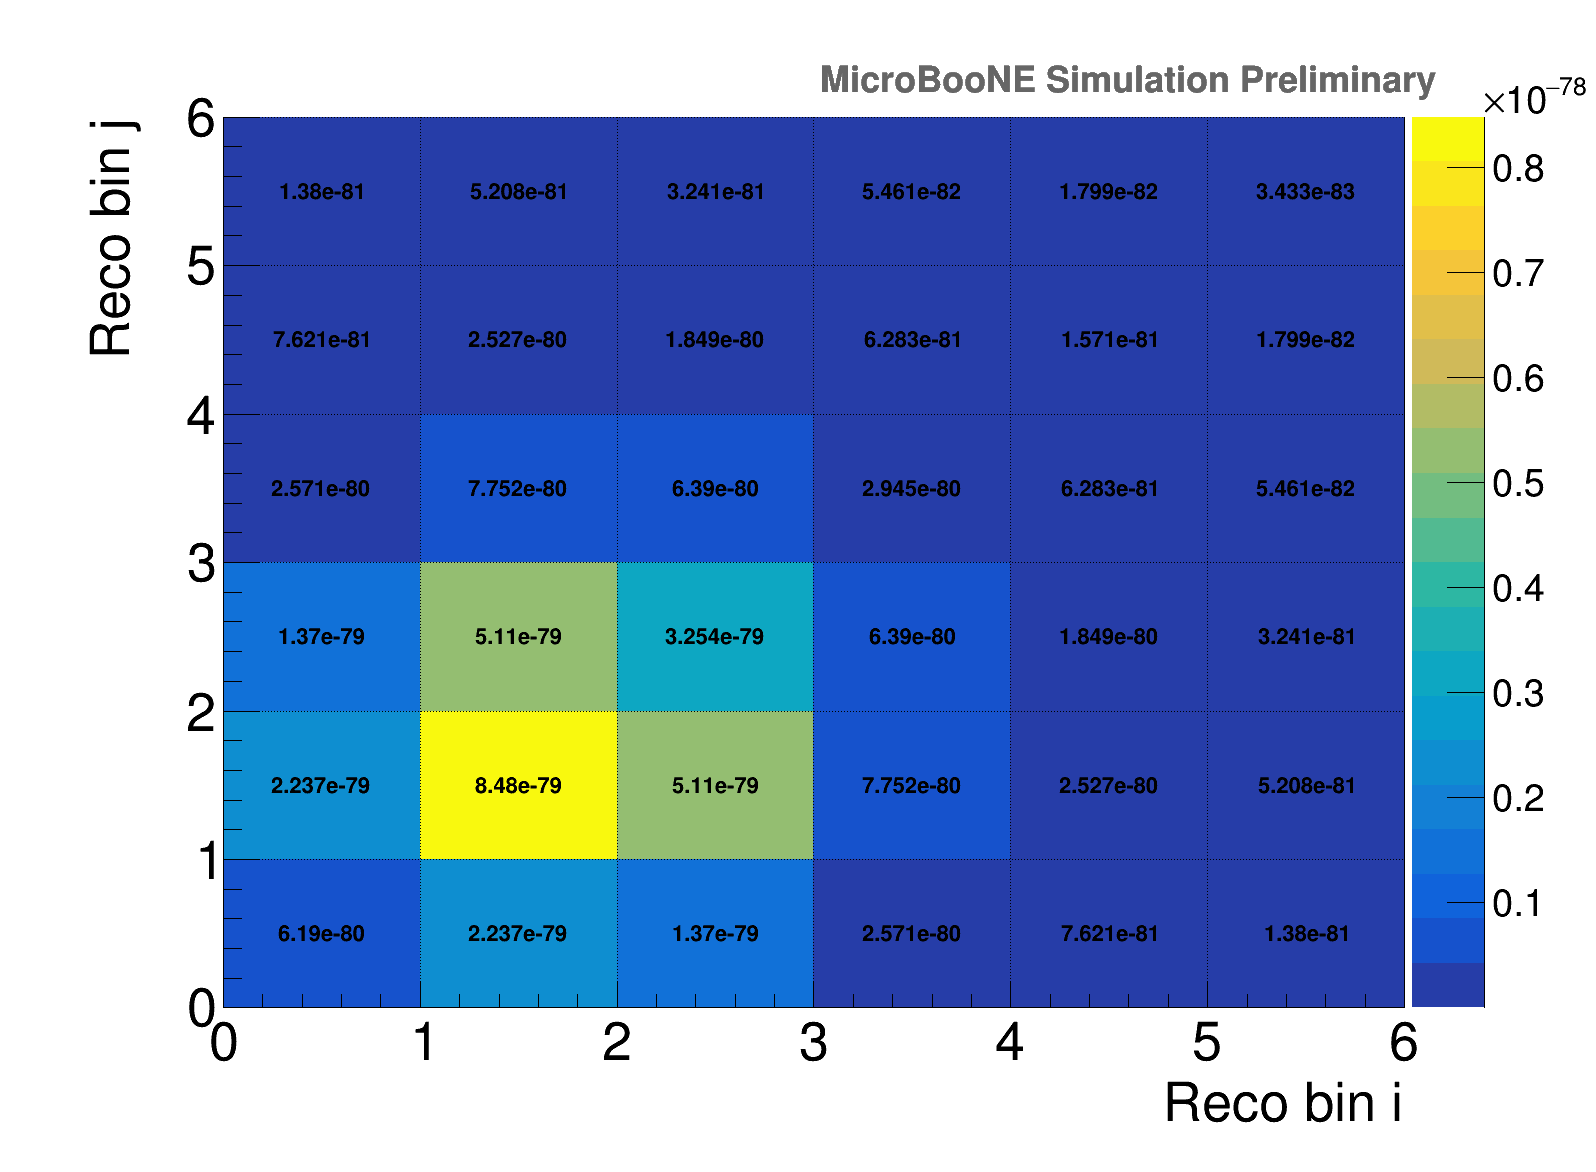

In [37]:
ROOT.gStyle.SetPaintTextFormat('0.4g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j]*1e-76)
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')
h_covariance.Draw('colz')
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_detsys.png")
c1.SaveAs(outputdir_root + "h_covariance_detsys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_detsys.pdf")
h_covariance.Write('h_covariance')

633

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_frac_covariance_detsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_frac_covariance_detsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_frac_covariance_detsys.pdf has been created


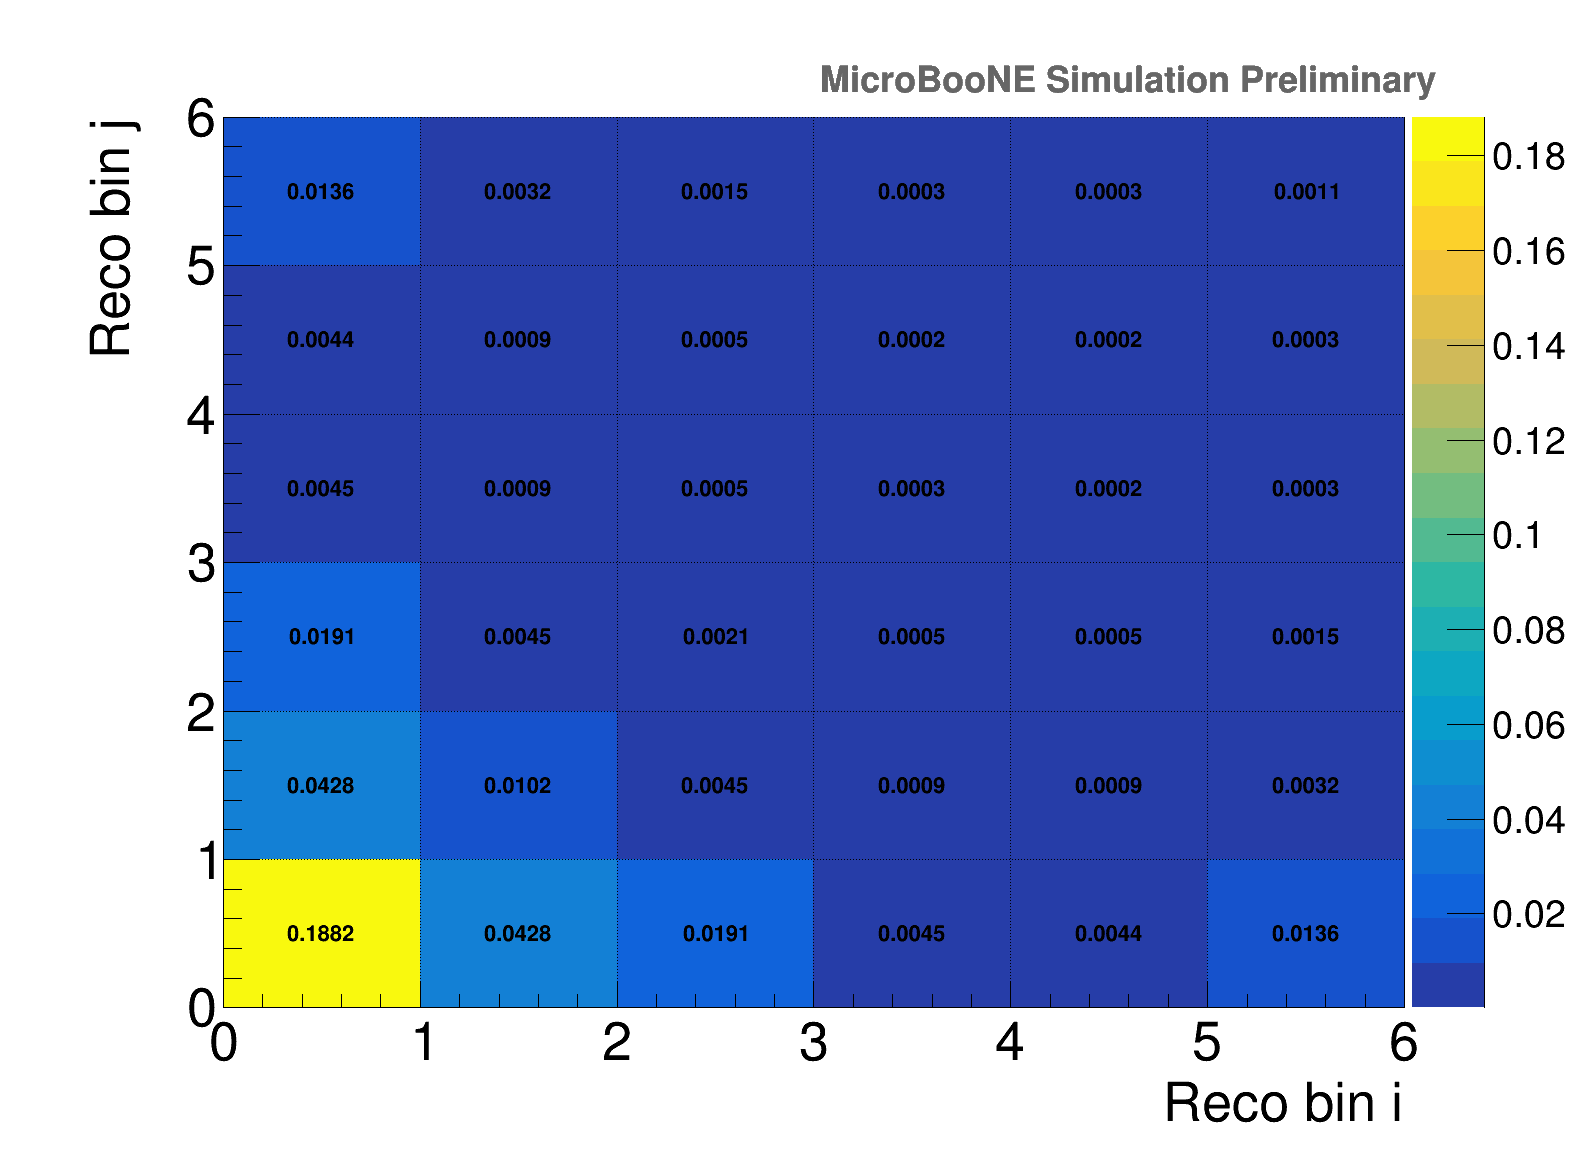

In [38]:
ROOT.gStyle.SetPaintTextFormat('0.4f')
h_frac_covariance = ROOT.TH2F("h_frac_covariance",'fractional covariance matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_frac_covariance.SetBinContent(i+1,j+1,xsec_frac_cov_matrix[i,j])
h_frac_covariance.SetXTitle("Reco bin i")
h_frac_covariance.SetYTitle("Reco bin j")
h_frac_covariance.GetYaxis().SetTitleSize(0.05)
h_frac_covariance.GetYaxis().SetTitleOffset(0.0)
h_frac_covariance.GetYaxis().SetLabelSize(0.05)
h_frac_covariance.GetXaxis().SetTitleSize(0.05)
h_frac_covariance.GetXaxis().SetLabelSize(0.05)
h_frac_covariance.GetXaxis().SetTitleOffset(1)
h_frac_covariance.SetLineColor(ROOT.kBlack)
h_frac_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4f')
h_frac_covariance.Draw('colz')
c1.SetLogz(0)
h_frac_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_covariance_detsys.png")
c1.SaveAs(outputdir_root + "h_frac_covariance_detsys.root")
c1.SaveAs(outputdir_pdf + "h_frac_covariance_detsys.pdf")
h_frac_covariance.Write('h_frac_covariance')

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_xsec_all_genie_stat_error.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_xsec_all_genie_stat_error.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_xsec_all_genie_stat_error.pdf has been created


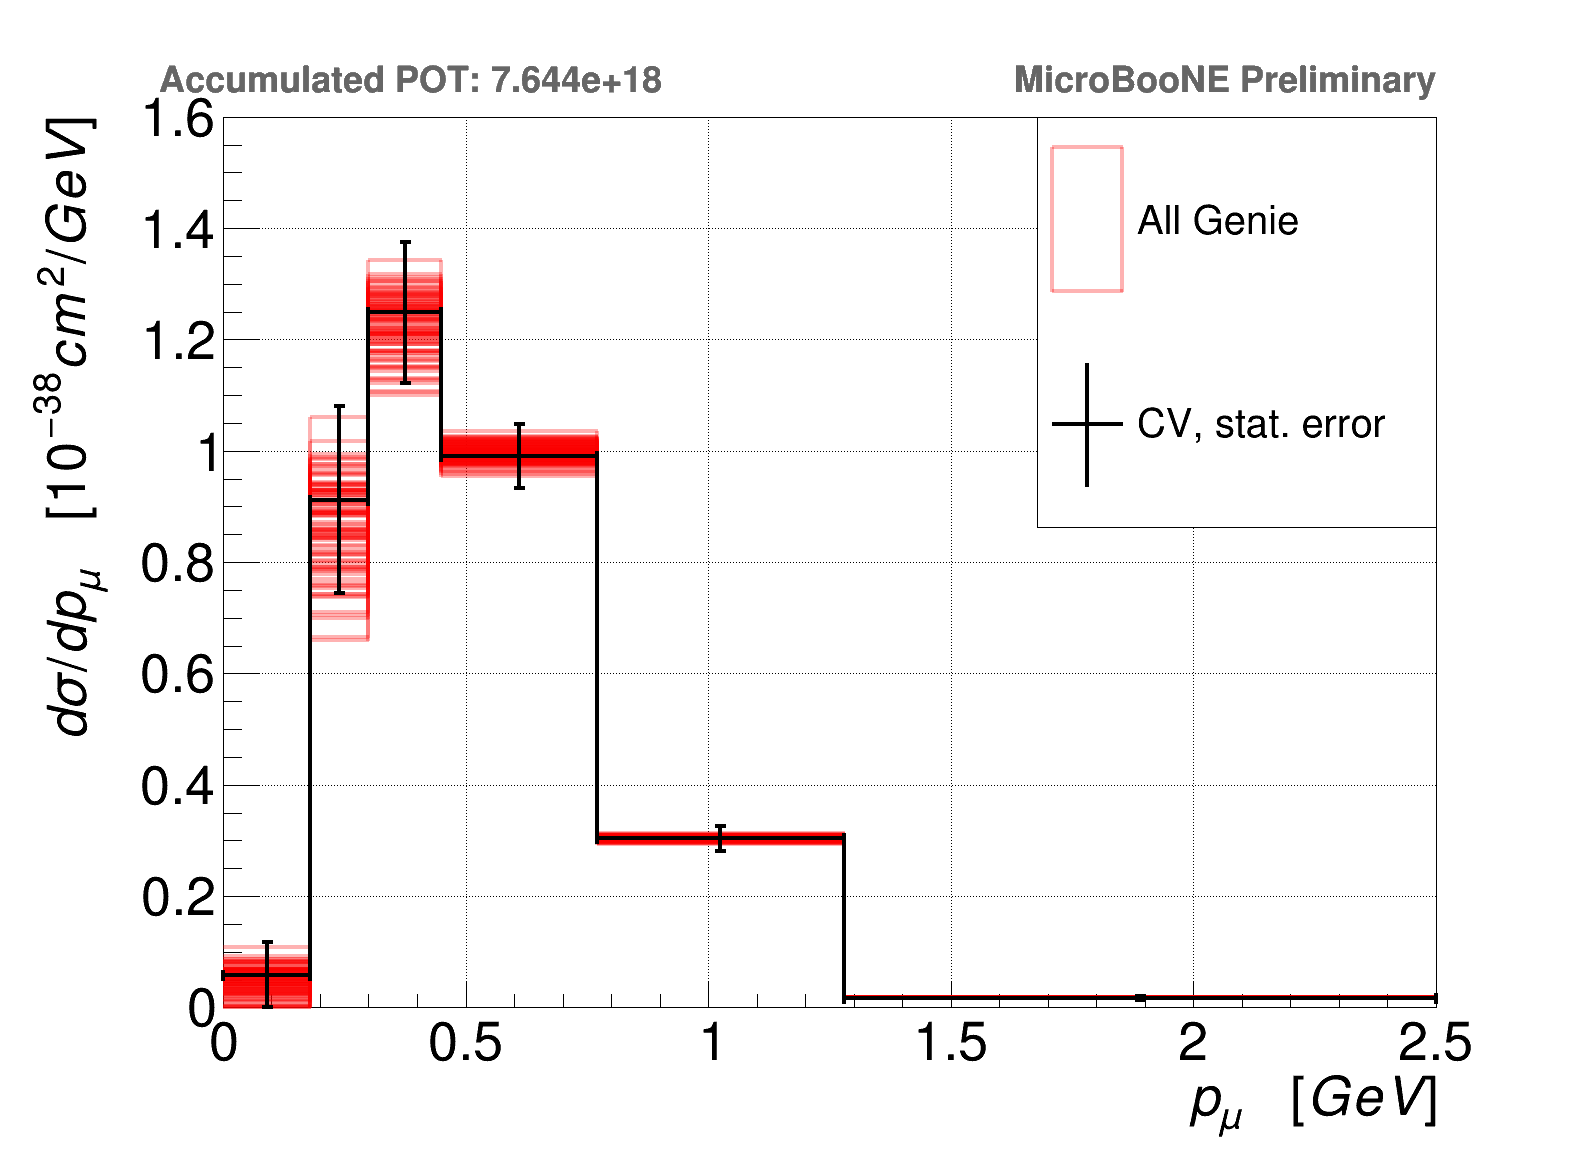

In [39]:
#with stat error
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
h_xsec_cv.Draw('hist')
for uni in range(num_universes): 
    h_xsec[uni].SetMaximum(1.6)
    h_xsec[uni].SetLineColorAlpha(ROOT.kRed,0.3)
    h_xsec[uni].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_xsec[uni].SetXTitle("p_{\mu} [GeV]")
    h_xsec[uni].GetYaxis().SetTitleSize(0.05)
    h_xsec[uni].GetYaxis().SetTitleOffset(0.0)
    h_xsec[uni].GetYaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleSize(0.05)
    h_xsec[uni].GetXaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleOffset(1)
    c1.SetRightMargin(0.1)
    #h_covariance.SetLineColor(ROOT.kBlack)
    h_xsec[uni].SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    h_xsec[uni].Draw('hist same')
legend.AddEntry(h_xsec[0],'All Genie',"f")
legend.AddEntry(h_xsec_cv,'CV, stat. error',"lep")
legend.Draw()
h_xsec_cv.SetLineColor(ROOT.kBlack)
h_xsec_cv.Draw('hist E1 same')  
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
h_stat = h_xsec_cv.Clone()

c1.SaveAs(outputdir_png + "h_xsec_all_genie_stat_error.png")
c1.SaveAs(outputdir_root + "h_xsec_all_genie_stat_error.root")
c1.SaveAs(outputdir_pdf + "h_xsec_all_genie_stat_error.pdf")

In [40]:
for i in range(num_bins):
    print math.sqrt(xsec_cov_matrix[i][i])

0.0248803747483
0.0920895950982
0.057045565607
0.0171621690378
0.00396309098225
0.000585901771403


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_xsec_all_genie_sys_error.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_xsec_all_genie_sys_error.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_xsec_all_genie_sys_error.pdf has been created


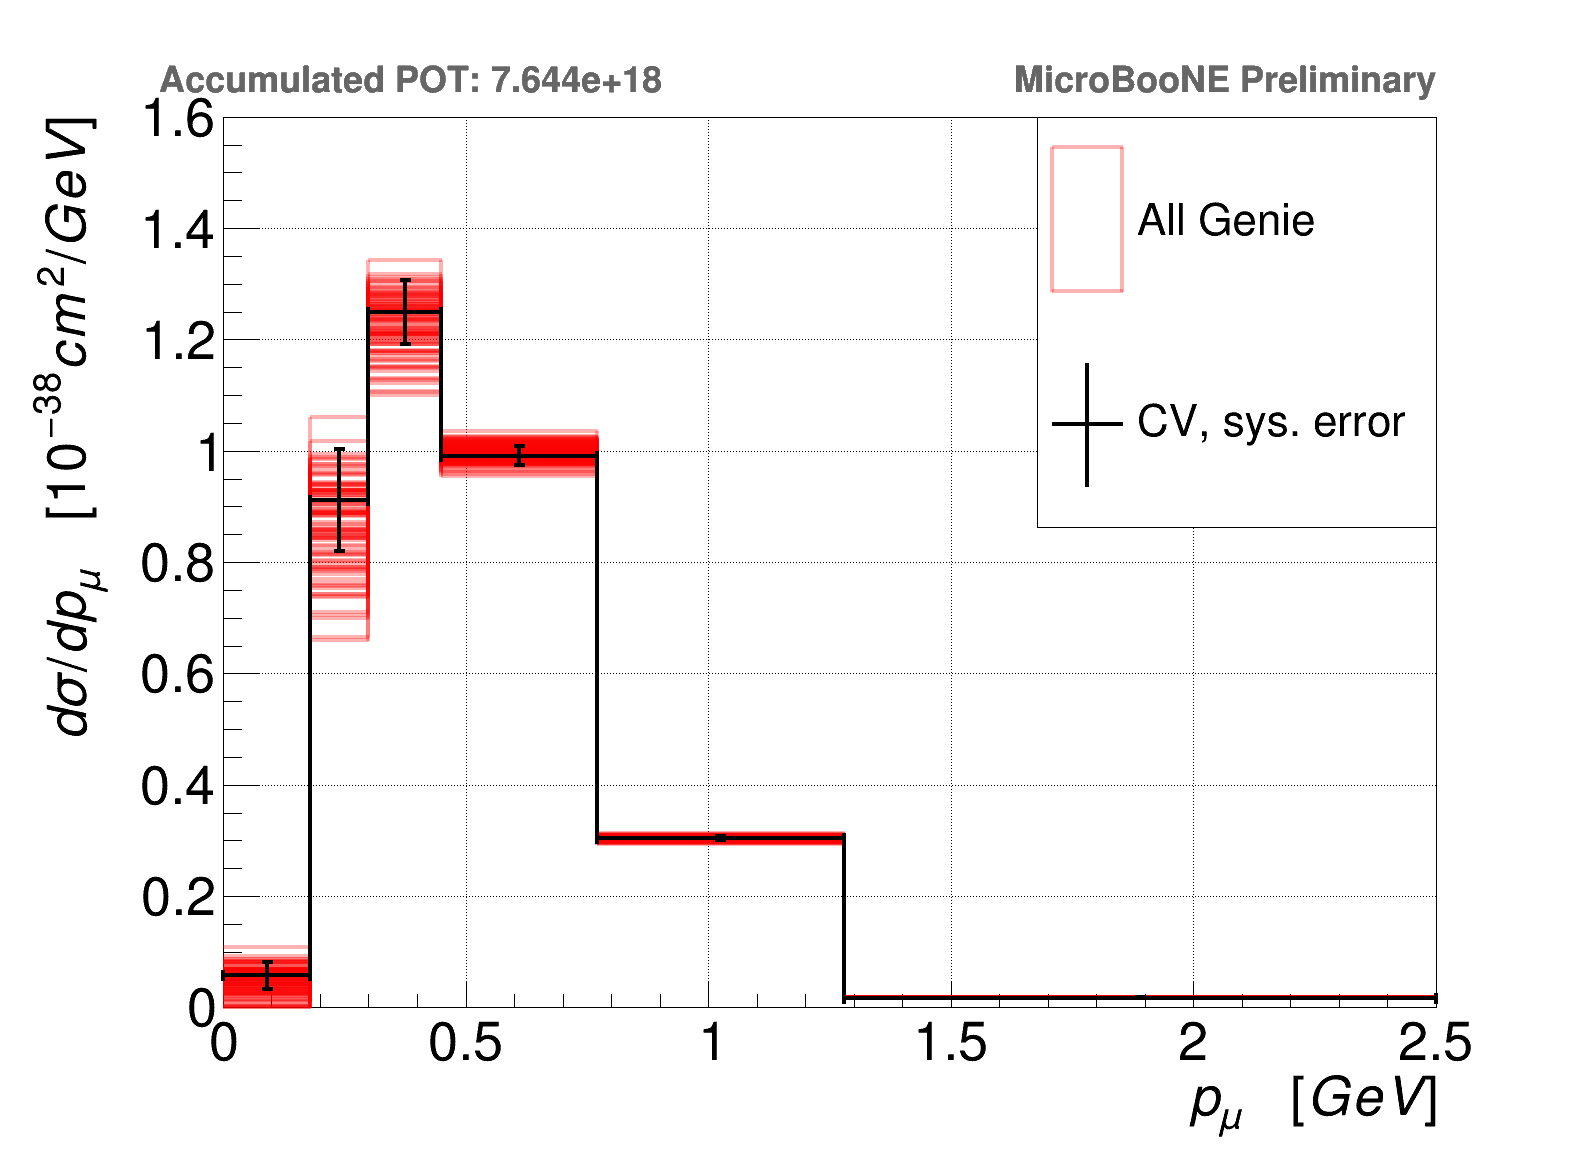

In [41]:
#with sys error
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
h_xsec_cv.Draw('hist')
for uni in range(num_universes): 
    h_xsec[uni].SetMaximum(1.6)
    h_xsec[uni].SetLineColorAlpha(ROOT.kRed,0.3)
    h_xsec[uni].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_xsec[uni].SetXTitle("p_{\mu} [GeV]")
    h_xsec[uni].GetYaxis().SetTitleSize(0.05)
    h_xsec[uni].GetYaxis().SetTitleOffset(0.0)
    h_xsec[uni].GetYaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleSize(0.05)
    h_xsec[uni].GetXaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleOffset(1)
    #h_covariance.SetLineColor(ROOT.kBlack)
    h_xsec[uni].SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    h_xsec[uni].Draw('hist same')
for i in range(num_bins):
    h_xsec_cv.SetBinError(i+1,math.sqrt(xsec_cov_matrix[i][i]))
legend.AddEntry(h_xsec[0],'All Genie',"f")
legend.AddEntry(h_xsec_cv,'CV, sys. error',"lep")
legend.Draw()
h_xsec_cv.Draw('hist E1 same')  
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_all_genie_sys_error.png")
c1.SaveAs(outputdir_root + "h_xsec_all_genie_sys_error.root")
c1.SaveAs(outputdir_pdf + "h_xsec_all_genie_sys_error.pdf")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/png/h_xsec_all_genie_tot_error.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/root/h_xsec_all_genie_tot_error.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine/pdf/h_xsec_all_genie_tot_error.pdf has been created


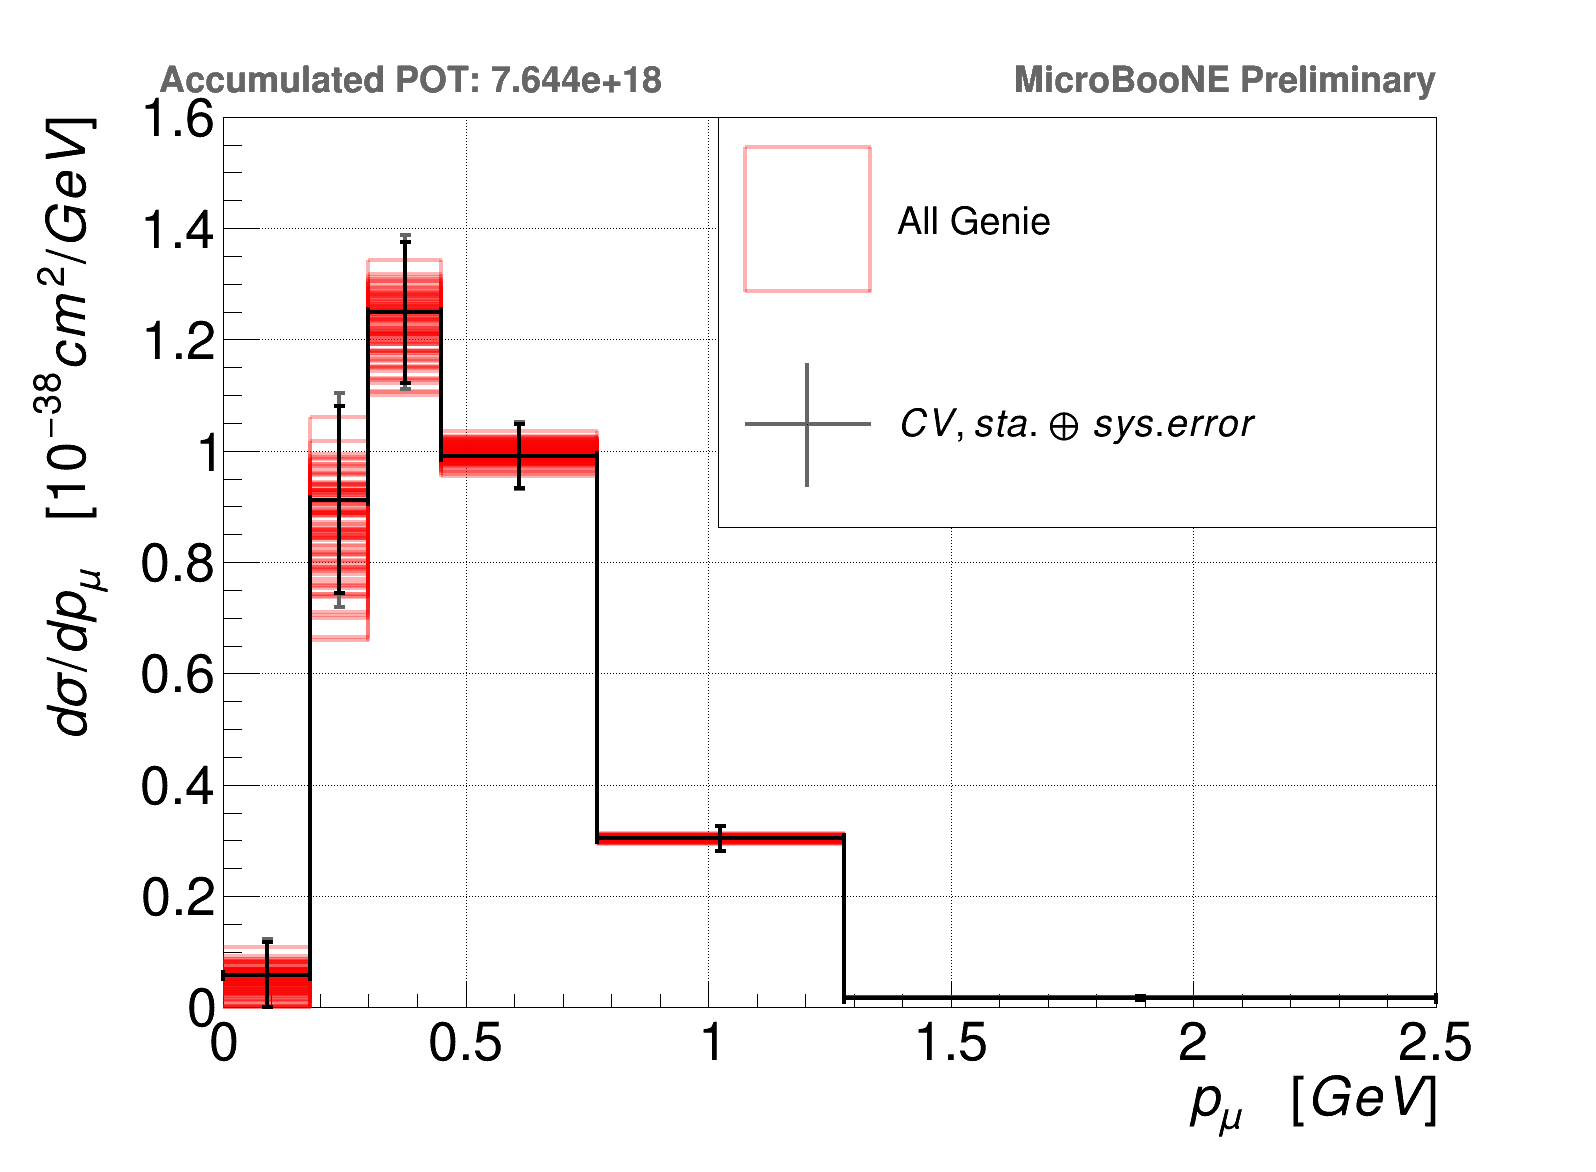

In [42]:
#with sys error
legend = ROOT.TLegend(0.45,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
h_xsec_cv.Draw('hist')
for uni in range(num_universes): 
    h_xsec[uni].SetMaximum(1.6)
    h_xsec[uni].SetLineColorAlpha(ROOT.kRed,0.3)
    h_xsec[uni].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_xsec[uni].SetXTitle("p_{\mu} [GeV]")
    h_xsec[uni].GetYaxis().SetTitleSize(0.05)
    h_xsec[uni].GetYaxis().SetTitleOffset(0.0)
    h_xsec[uni].GetYaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleSize(0.05)
    h_xsec[uni].GetXaxis().SetLabelSize(0.05)
    h_xsec[uni].GetXaxis().SetTitleOffset(1)
    #h_covariance.SetLineColor(ROOT.kBlack)
    h_xsec[uni].SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    h_xsec[uni].Draw('hist same')
for i in range(num_bins):
    h_xsec_cv.SetBinError(i+1,math.sqrt(xsec_cov_matrix[i][i]+math.pow(h_stat.GetBinError(i+1),2)))
h_xsec_cv.SetLineColor(ROOT.kGray+2)
legend.AddEntry(h_xsec[0],'All Genie                 ',"f")
legend.AddEntry(h_xsec_cv,'CV, sta. \oplus sys. error',"lep")
#legend.AddEntry(h_stat,'CV, stat. error',"lep")
legend.Draw()
h_xsec_cv.Draw('hist E1 same') 
h_stat.SetLineColor(ROOT.kBlack)
h_stat.Draw('hist E1 same')
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_all_genie_tot_error.png")
c1.SaveAs(outputdir_root + "h_xsec_all_genie_tot_error.root")
c1.SaveAs(outputdir_pdf + "h_xsec_all_genie_tot_error.pdf")

In [43]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
num_universes = 100
eff_uni = np.zeros((num_universes))
mom_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]
binnum = len(mom_bins) - 1

In [44]:
# close the root file with all the histos
RootFile.Close()